# Classifying Spectral Data using Convolution Neural Networks

- The dataset I will be classifying is [ESC-50](https://github.com/karoldvl/ESC-50). Its a labeled collection of 2000 environmental audio recordings suitable for benchmarking methods of environmental sound classification.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
from collections import Counter
import random

#used to play audio files within notebook
from ipywidgets import interact
from IPython.display import Audio
from IPython.display import display

#audio file processing
import librosa
from scipy import signal
from scipy.io import wavfile

#used to correct imbalanced data set through boostrap sampling
from imblearn.over_sampling import RandomOverSampler

Using TensorFlow backend.


## Import and Process the data
Download the ESC-50 dataset using this [link](https://github.com/karoldvl/ESC-50/archive/master.zip) and upzip it within the "data" folder

In [2]:
audioFiles = os.path.abspath('data/ESC-50-master/audio/')
fileInfo = os.path.abspath('data/ESC-50-master/meta/esc50.csv')

#read in metaData
fileInfo_DF = pd.read_csv(fileInfo)
print('Number of sound files: %d'%fileInfo_DF.shape[0])
print('Number of categories: %d'%fileInfo_DF['category'].nunique())
fileInfo_DF.head()

Number of sound files: 2000
Number of categories: 50


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


Count the number examples per class. A balanced training set is preferred for creating a model. Prevents the classifier from favoring the accuracy of one class over others

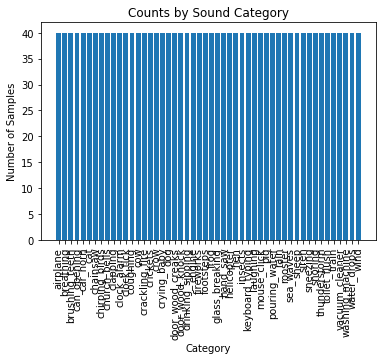

In [3]:
CategoryCounts = fileInfo_DF.groupby('category').count()['filename']

plt.bar(CategoryCounts.index, CategoryCounts)
plt.xticks(rotation='vertical')
plt.title('Counts by Sound Category')
plt.xlabel('Category')
plt.ylabel('Number of Samples')
plt.show()


Create a function for reading the wav files and converting them to Spectrograms

In [4]:
#load sound files and convert them to spectograms

def getSpectrogram(idx):  #where idx is the file index as stored by the fileInfo_DF
    sample_rate, wave = wavfile.read(os.path.join(audioFiles, fileInfo_DF['filename'][idx])) #read in file

    #sound byte padding changes
    #remove 0 padding from end of wave. It was used to make all clips 5 seconds. Won't be needed for our analysis
    wave = np.trim_zeros(wave, trim='b')
    #pad either end with 0.5 seconds of audio. Needed for more samples when splitting shorter sound bytes
    wave = np.insert(wave, 0, np.zeros(sample_rate//2))
    wave = np.insert(wave, len(wave), np.zeros(sample_rate//2))
    
    #normalize wave
    #normalize 16 bit signal by diving by max
    wave = wave.astype(float)
    wave = wave.astype(float) + 0.5 / ((2**16 -1) / 2) 
    #scale amplitudes from -1 to 1 wave by dividing by max
    wave = wave / np.max(np.abs(wave))

    #convert spectrogram amplitudes to decibels using log
    spectrogram = librosa.feature.melspectrogram(wave, sr=sample_rate)
    spectrogram = librosa.core.amplitude_to_db(spectrogram)

    return spectrogram

The ESC-50 sound data only gives 40 samples per class. Seperating samples into shorter snippets will allow us to have more training data

In [5]:
def splitSpectrogram(idx, length=100, skip=10):
    spectrogram = getSpectrogram(idx)
    samples = []
    
    #iterate through spec columnns by skip count, and seperate
    c = 0
    while (c + length) <= spectrogram.shape[-1]:
        split = spectrogram[:, c:c+length]
        #check if each split contains enough audio to classify. Found 99.5, and -10 through experimentation
        if np.percentile(split,99.5) > -10:
            #plt.imshow(split ,origin='lower')
            #plt.show()
            samples.append(split)
        c += skip
    soundLabel = fileInfo_DF['category'][idx]
    return [soundLabel,]*len(samples), samples

Quick test to see if both functions work

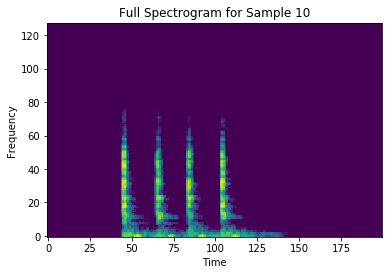

In [6]:
#test splitting spectrogram
sample_idx = 10
sample_spec = getSpectrogram(sample_idx)

#chart full spectrogram
plt.imshow(sample_spec, origin='lower')
plt.title('Full Spectrogram for Sample %d'%sample_idx)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

#chart splits
a,b = splitSpectrogram(sample_idx)

assert len(a) == len(b)

## Create a "viewer"

In [7]:
#allows user to play different samples without rerunning cell
@interact(idx=(0,len(fileInfo_DF)))
def playAudio(idx):
    sample_rate, wave = wavfile.read(os.path.join(audioFiles, fileInfo_DF['filename'][idx])) #read in file
    
    #Display audio player
    display(Audio(wave, rate=sample_rate))
    
    #normalize wave
    #normalize 16 bit signal by diving by max
    normWave = wave.copy().astype(float)
    normWave = normWave + 0.5 / ((2**16 -1) / 2) 
    #scale amplitudes from -1 to 1 wave by dividing by max
    normWave = normWave / np.max(np.abs(normWave))
    
#     plt.plot(normWave)
#     plt.show()
    
    #convert spectrogram amplitudes to decibels using log
    spectrogram = librosa.feature.melspectrogram(normWave, sr=sample_rate)
    spectrogram = librosa.core.amplitude_to_db(spectrogram)
    
    #get the spectrogram splits
    labels, splits = splitSpectrogram(idx)
    
    
    #charting
    numSecs = wave.size/sample_rate
    xTicks = np.arange(0, numSecs, 1/sample_rate)
    
    #chart spectrogram and splits
    fig = plt.figure(figsize=(12, 6))
    grid = plt.GridSpec(4, 5, wspace=0.1, hspace=0.1)
    full_spec = fig.add_subplot(grid[0:2, :])
    
    #chart the full spectrogram
    full_spec.imshow(spectrogram, origin='lower')
    full_spec.axis('off')
    full_spec.set_aspect('auto')
    
    #select and chart a random set of spectrogram splits
    randSplits = random.sample(range(len(splits)), min(len(splits), 10))
    for i in range(len(randSplits)):
        ax = fig.add_subplot(grid[2 + i//5, i%5])
        ax.imshow(splits[randSplits[i]], origin='lower')
        ax.axis('off')
        ax.set_aspect('auto')
    
    fig.suptitle('Spectrogram and Splits for Sample %d - %s'% (idx, str.upper(fileInfo_DF['category'][idx])))
    plt.show()

interactive(children=(IntSlider(value=1000, description='idx', max=2000), Output()), _dom_classes=('widget-int…

## Create Label and Feature Arrays
Used split spectrograms to create a training data matrix X. Ensure that label (y) integrity is kept.
After splitting the spectrograms there are now 72,000 sound samples as opposed to just 2,000

In [8]:
X = []
y = []

for i in range(len(fileInfo_DF)):
    tempY, tempX = splitSpectrogram(i)
    X += tempX  #add new list of splits
    y += tempY
X = np.array(X) #convert to numpy array
y = np.array(y)
print(X.shape)
print(y.shape)

(72113, 128, 100)
(72113,)


Recounting the number of training samples for each category. Notice that the counts now vary. This is because before splitting the spectrogram I removed the audios end padding used to make the files 5 seconds. Now, some of the categories have shorter sound files on average, therefore less snippets when split.

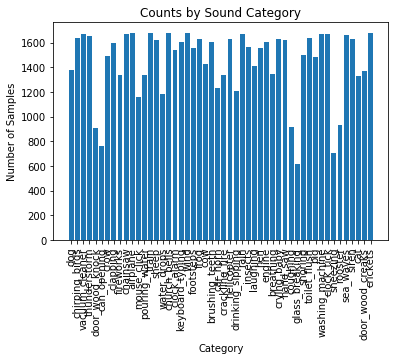

In [9]:
from collections import Counter

#count the number of samples for each class
counter = Counter()
counter.update(y)

plt.bar(counter.keys(), counter.values())
plt.xticks(rotation='vertical')
plt.title('Counts by Sound Category')
plt.xlabel('Category')
plt.ylabel('Number of Samples')
plt.show()

To correct the class imbalance use oversampling

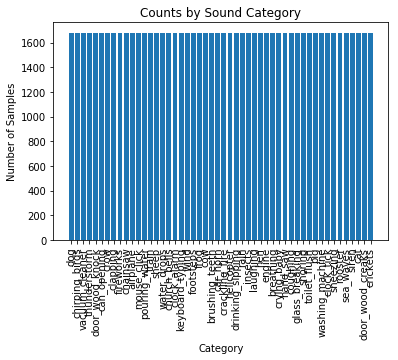

In [10]:
#need to use X indexes instead, because class only accepts 2D arguments
X_indexes = np.arange(len(X)).reshape(-1,1)

overSampler = RandomOverSampler()
rebal_X_idx, rebal_y = overSampler.fit_resample(X_indexes, y)

#used resampled x indexes to construct balanced X
rebal_X = X[rebal_X_idx]
assert len(rebal_X) == len(rebal_y)

#count the number of samples for each class
counter = Counter()
counter.update(rebal_y)

plt.bar(counter.keys(), counter.values())
plt.xticks(rotation='vertical')
plt.title('Counts by Sound Category')
plt.xlabel('Category')
plt.ylabel('Number of Samples')
plt.show()

Add a "delta" channel to the spectrograms. Having a feature that tracks the change in amplitude over frequency and time has been shown to greatly improve model performance

C:\Users\josep\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\josep\Anaconda3\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


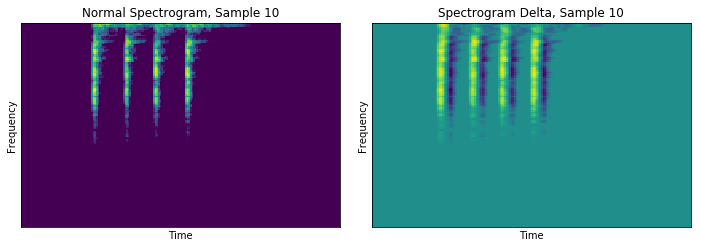

In [31]:
sample_idx = 10
sample_spec = getSpectrogram(10)
delta = librosa.feature.delta(sample_spec)

#create shared plot
fig = plt.figure(figsize=(12, 6))
grid = plt.GridSpec(1, 2, wspace=0.1, hspace=0.1)
ax_spec = fig.add_subplot(grid[0, 0])
ax_delta = fig.add_subplot(grid[0, 1])

#plot regular spectrogram
ax_spec.imshow(sample_spec)
ax_spec.set_title('Normal Spectrogram, Sample %d'%sample_idx)
ax_spec.set_xlabel('Time')
ax_spec.set_ylabel('Frequency')
ax_spec.set_xticks([])
ax_spec.set_yticks([])

#plot example delta
ax_delta.imshow(delta)
ax_delta.set_title('Spectrogram Delta, Sample %d'%sample_idx)
ax_delta.set_xlabel('Time')
ax_delta.set_ylabel('Frequency')
ax_delta.set_xticks([])
ax_delta.set_yticks([])
fig.show()


In [37]:
#create the delta feature and stack it onto X as a new channel
Xd = np.array([librosa.feature.delta(spec) for spec in X])
print(Xd.shape)

#combine with the earlier cells
X_2 = np.stack((X,Xd), axis=-1)
print(X_2.shape)

C:\Users\josep\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


(72113, 128, 100)


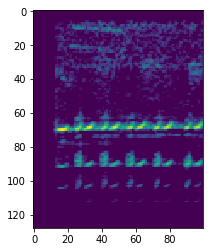

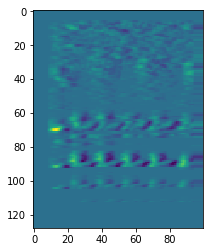

In [39]:
# plt.imshow(X[sample_idx])
# plt.show()
# plt.imshow(deltas[sample_idx])
# plt.show()

In [41]:
# #combine with the earlier cells
# X_2 = np.stack((X,deltas), axis=-1)
# X_2.shape

(72113, 128, 100, 2)

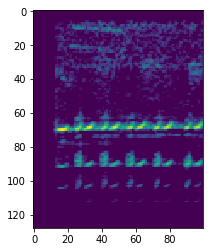

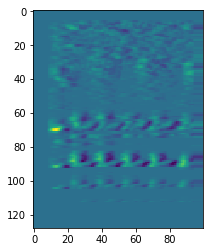

In [43]:
# plt.imshow(X_2[sample_idx,:,:,0])
# plt.show()
# plt.imshow(X_2[sample_idx,:,:,1])
# plt.show()

In [ ]:
#renormalize data


In [54]:
#convert y from categorical using OHE
def OHE(y):
    cols = max(y) - min(y) + 1
    encoded = list()
    for i in range(len(y)):
        row = np.zeros((cols)).astype(int)
        print(row)
        row[y[i]-1] = 1
        encoded.append(row)
    return np.array(encoded)

y = [1,2,3,4]
OHE(y)

[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]


array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])

# Create a CNN model

The CNN layer arcitecture I used is modeled after the linked repository:
[reference CNN](https://github.com/karoldvl/paper-2015-esc-convnet)

# Resources

[note classification](https://towardsdatascience.com/audio-classification-using-fastai-and-on-the-fly-frequency-transforms-4dbe1b540f89)

[filter banks](https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html)

[other filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html#scipy.signal.savgol_filter)